# Binary Prediction - Kaggle Rainfall Dataset
## Author: Max Rong

Description: This project is from Kaggle's playground series(Playground Series - Season 5, Episode 3). As it's name indicates, the project aims to predict rainfall for a particular day in the year based off a training dataset provided by kaggle.

Todo:
- Better Data Preprocessing 
    - [ ] Research Data Preprocessing methods - normalization, scaling, etc.
    - Feature Engineering
        - [ ] Add autoregressive feature(previous value of rainfall, pressure change, temp change)
        - [ ] Research more possible features
            - How can I utilize maxtemp?
            - Stormfront? with cloud, sunshine, winddirection, windspeed
            - pressure change? Does it relate to rain
            - Humidity with dewpoint, does "wetness" relate to rain?
- Improve data visualization
    - [ ] Clean up correlation plot
    - [ ] Add legend to rainfall count plot by month
    - [ ] Add legend to rainfall count plot by season
    - [ ] More plots?
- Model Training
    - [ ] Train initial model with current features to get benchmark

Notes: 
- Current features:
    id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,month,season,year


# Importing Libraries

In [15]:
# Imports
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.graphics.tsaplots import plot_acf


# Data Prep

In [5]:
# load dataframe
weather_df = pd.read_csv("datasets/train.csv")
print("df dimensions:", weather_df.shape)

# Clean data
remove_bad_rows(weather_df)

# Check for leap years before adding features
print("Checking for leap years:", weather_df.loc[weather_df['day']==366].index) # No leap years found\
    
# Add Features(work becomes a lot easier without leap years)
# Date features
add_date_features(weather_df)


# Print DF
print(weather_df.head())
print(weather_df.tail())

df dimensions: (2190, 13)
Checking for leap years: Index([], dtype='int64')
   id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   

   cloud  sunshine  winddirection  windspeed  rainfall  week  month  season  \
0   88.0       1.1           60.0       17.2         1     1      1       1   
1   91.0       0.0           50.0       21.9         1     1      1       1   
2   47.0       8.3           70.0       18.1         1     1      1       1   
3   95.0       0.0           60.0       35.6         1     1      1       1   
4   45.0       3.6           40.0       24.8         0     1      1       1   

## Data Exploration

In [31]:
# Is there an imbalance in the data?
print("Rainy Days : Non-Rainy Days ")
print(weather_df['rainfall'].value_counts())

Rainy Days : Non-Rainy Days 
rainfall
1    1650
0     540
Name: count, dtype: int64


Note: There are far more rainy days than dry days. This might lead to potential bias.

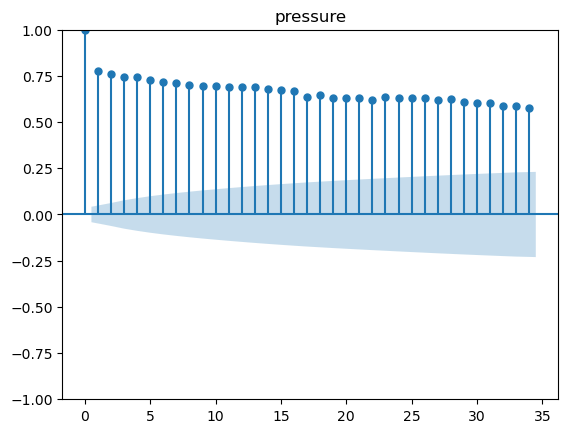

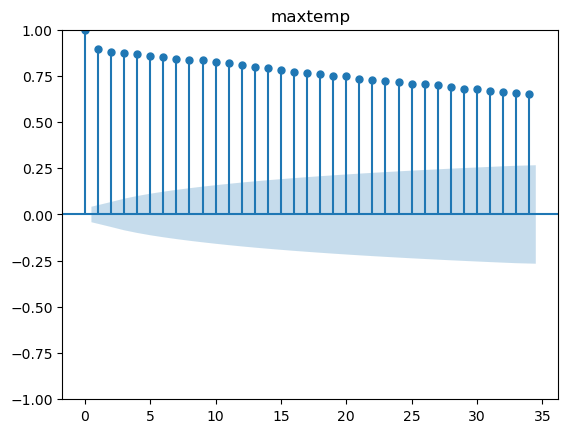

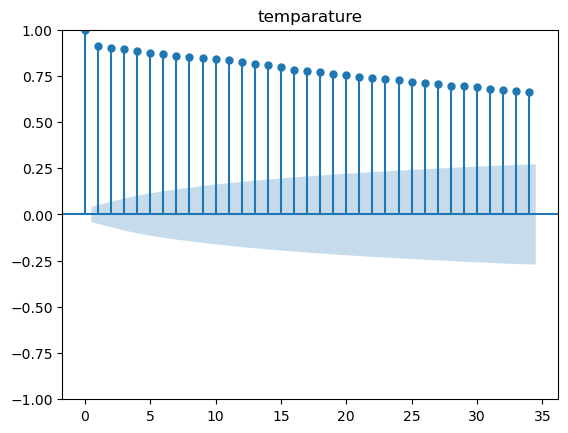

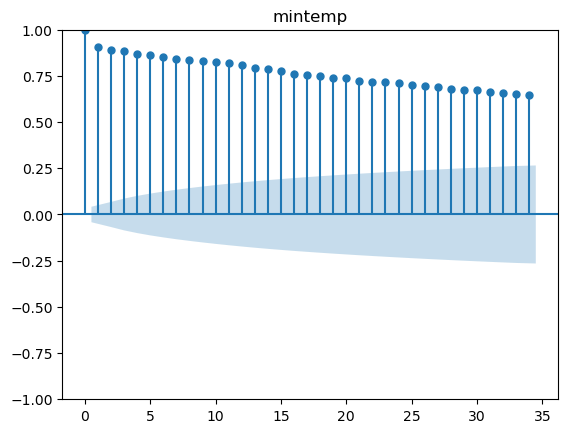

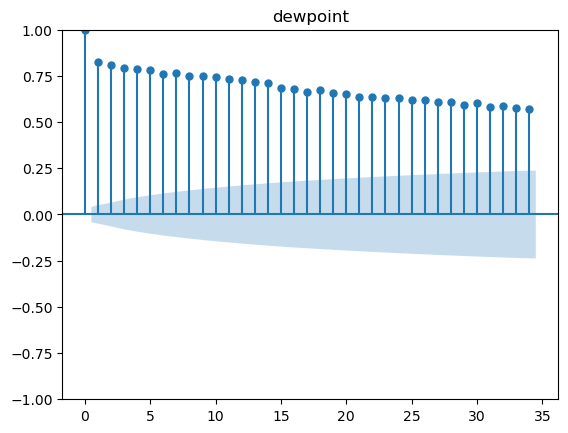

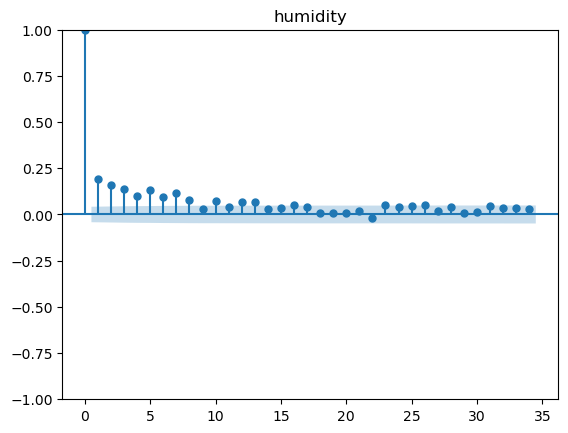

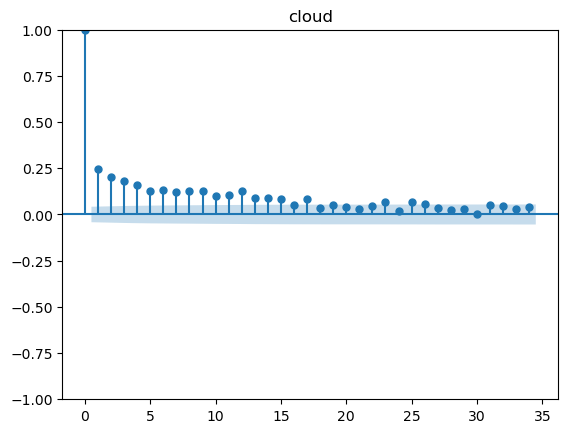

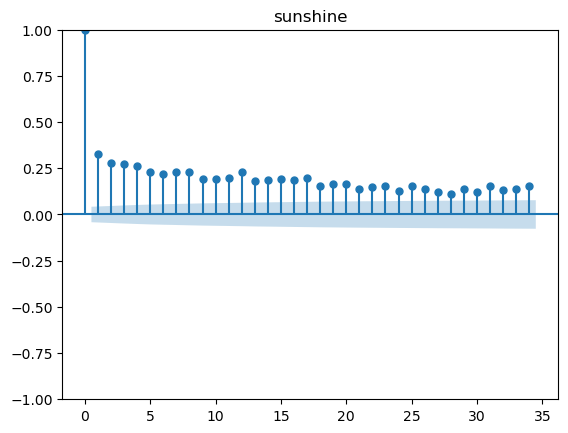

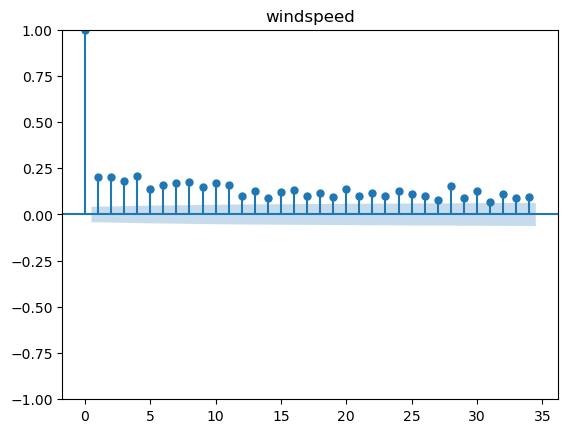

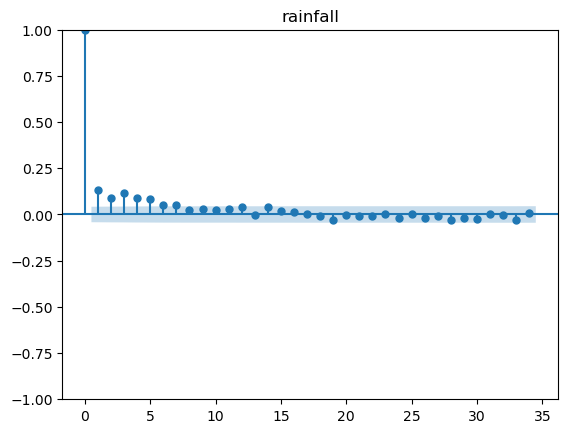

In [42]:
# Are autoregresssive features worth it? Check ACF for each feature that is expected to be autocorrelated
for col in ['pressure', 'maxtemp', 'temparature', 'mintemp', 
            'dewpoint', 'humidity', 'cloud', 'sunshine', 
            'windspeed', 'rainfall']:
    plot_acf(weather_df[col], title=col)


## Feature Creation

In [4]:
# dropna values, drop duplicates, reset index to remove gaps
def remove_bad_rows(df):
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

def add_date_features(df):
    # Add week, month, season, year columns
    add_week(df)
    add_month(df)
    add_season(df)
    add_year(df)

# add week column to df
def add_week(df):
    # note: Dividing each year into a uniform number of weeks and having equivalent days correspond
    # to equivalent weeks instead of counting weeks by Sun-Sat is a more accurate data point, and 
    # true week will not diverge by much
    df['week'] = df['day'].apply(lambda x: (x//7)+1)

# Add month column to df
def add_month(df):
    df['month'] = df['day'].apply(day_to_month)  

# Add season column to df
def add_season(df):
    df['season'] = df['month'].apply(month_to_season) 

# Convert day index(1-31) to month index(1-12)
def day_to_month(x):
    # map the day that corresponds to the end of each month(1-12)
    cutoffs = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
    for i in range(len(cutoffs)):
        if x <= cutoffs[i]:
            return (i+1)

# Convert month index(1-12) to seasons index(1-4)
def month_to_season(month):
    # map each month to a season
    lookup = {
        12: 1, 1: 1, 2: 1,    # winter
        3: 2, 4: 2, 5: 2,     # spring
        6: 3, 7: 3, 8: 3,     # summer
        9: 4, 10: 4, 11: 4    # fall
    }
    return lookup[month]

# Add year column to df
def add_year(df):
    # In this case, we can assume each id corresponds to a specific day
    # Thus we can classify id = total days since beginning observation
    # So we use id to get year
    df['year'] = df['id'].apply(lambda x: (x//365)+1)

## Visualize data

<Axes: xlabel='month', ylabel='count'>

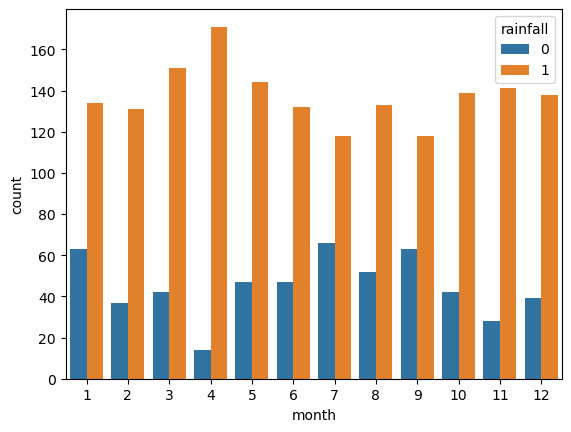

In [95]:
# Rainfall Count by Month

sns.countplot(x='month', hue='rainfall', data=weather_df)

<Axes: xlabel='season', ylabel='count'>

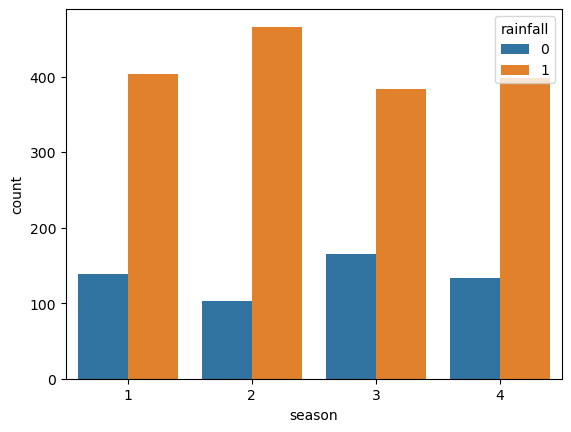

In [96]:
# Rainfall Count by Season

sns.countplot(x='season', hue='rainfall', data=weather_df)

<Axes: >

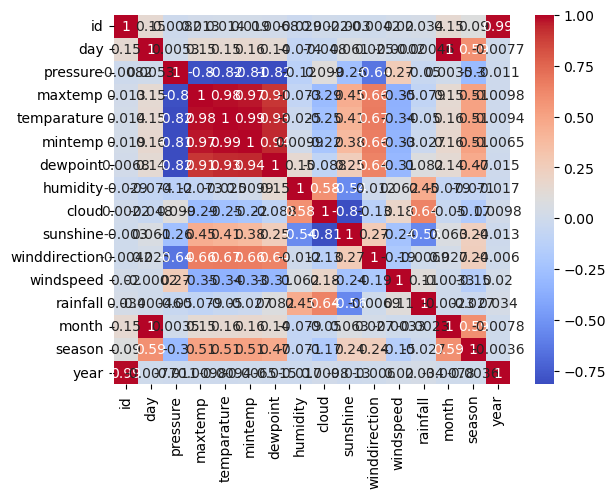

In [97]:
# Correlation heatmap

sns.heatmap(weather_df.corr(), cmap='coolwarm', annot=True)


# Model Training

In [17]:
# Split training dataset into train and test sets
X = weather_df.drop(['rainfall'], axis=1)  
y = weather_df['rainfall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Train initial first model
reg_1 = xgb.XGBClassifier(n_estimators=1000, max_depth=5, early_stopping_rounds=50, learning_rate=0.01, n_jobs=-1)
reg_1.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)], 
          verbose=100
          )

[0]	validation_0-logloss:0.54784	validation_1-logloss:0.58097
[100]	validation_0-logloss:0.32152	validation_1-logloss:0.41671
[200]	validation_0-logloss:0.25115	validation_1-logloss:0.39311
[281]	validation_0-logloss:0.22052	validation_1-logloss:0.39368


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

## Check feature importance

<Axes: >

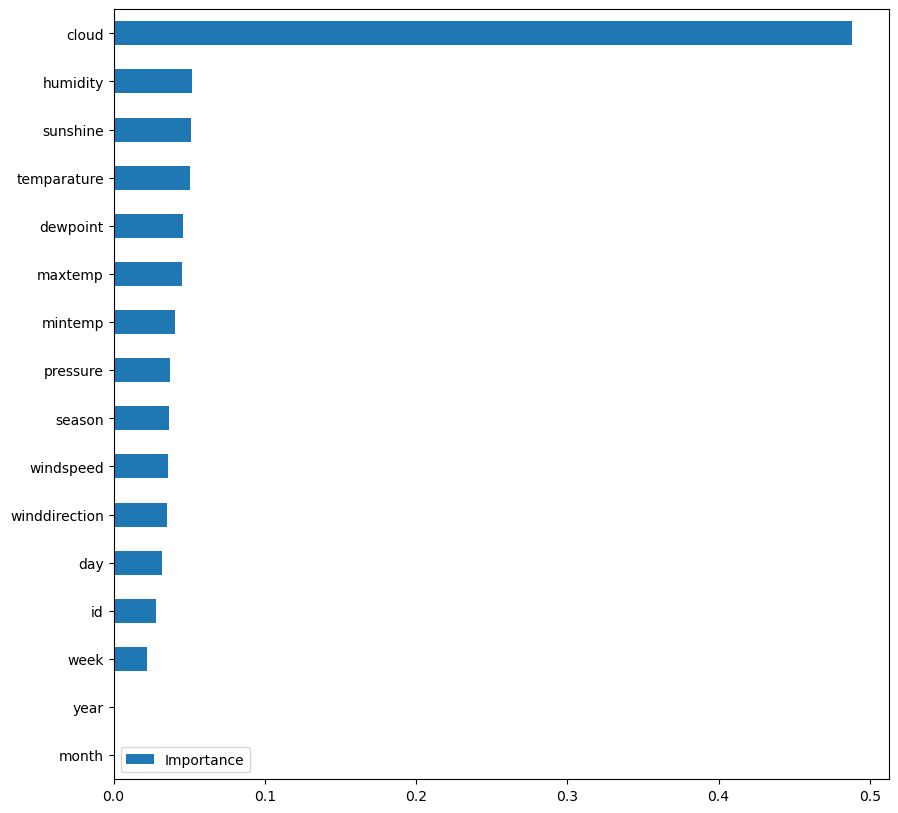

In [23]:
fi = pd.DataFrame(data=reg_1.feature_importances_,
                  index = reg_1.feature_names_in_,
                  columns=['Importance'])

fi.sort_values(by='Importance', ascending=True, inplace=True)

fi.plot(kind='barh', figsize=(10,10))

In [ ]:
# Model Eval
y_pred = reg_1.predict(X_test)

# Print aaccuracy, classification report, confusion matrix
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.59      0.67       119
           1       0.86      0.93      0.89       319

    accuracy                           0.84       438
   macro avg       0.81      0.76      0.78       438
weighted avg       0.83      0.84      0.83       438

Confusion Matrix:
[[ 70  49]
 [ 21 298]]
